# Hierarchical clustering and image segmentation

In [1]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator

## Hierarchical clustering

Remember that you can find an example of dendogram [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html)

### Loading the dataset 'cities_coordinates.txt'

In [2]:
def load_cities(filename="cities_coordinates.txt"):
    """Return city coordinates (X) and their names (y)"""
    X = []
    y = []
    with open(filename, 'r') as cities:
        for line in cities.readlines():
            data = line.split(",")
            X.append(data[0:-1])
            y.append(data[-1].split("\n")[0])
    X = np.array(X).astype(float)
    y = np.array(y).astype(str)
    return X, y

X, y = load_cities()

print("Shape of datapoints: ", X.shape)
print("Shape of targets:    ", y.shape)

Shape of datapoints:  (30, 3)
Shape of targets:     (30,)


The cell below is adapted from [there](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html)

In [3]:
def plot_dendrogram(model, y):
    """
    Create linkage matrix and then plot (and return) the dendrogram
    """

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Initialize figure
    fig, ax = plt.subplots(figsize=(15,5))

    # Plot the corresponding dendrogram
    # dendo is a dictionnary containing many info, notably the indices
    # of leaves and their corresponding cluster
    dendo = dendrogram(linkage_matrix, labels=y, ax=ax)
    return fig, ax, dendo


In [4]:
def plot_3D_coordinates(X, dendogram):
    """
    X represents the coordinates of all cities
    dendogram the output of the dendogram function in scipy
    """
    # Indices of the leaves
    leaves = dendogram["leaves"]
    # Clusters for each leaf
    clusters = dendogram["leaves_color_list"]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(X[leaves,0], X[leaves, 1], X[leaves, 2], c=clusters)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    return fig, ax
    

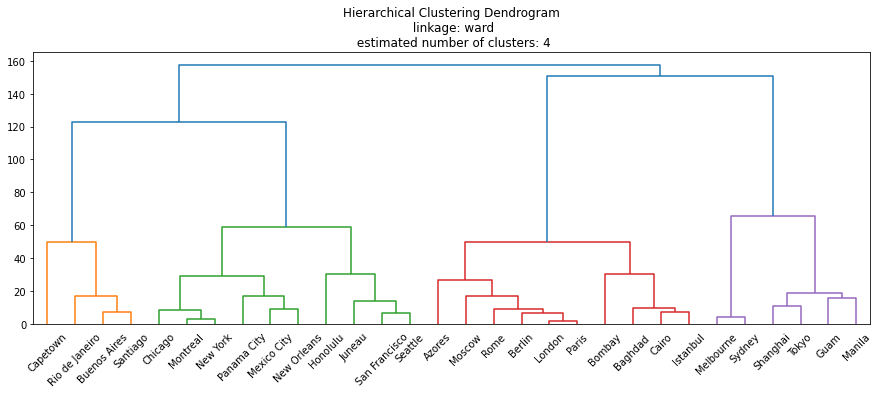

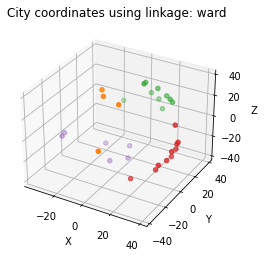

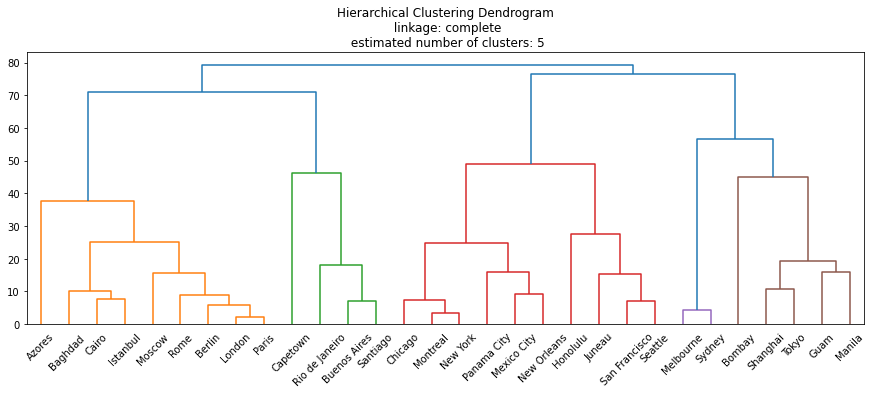

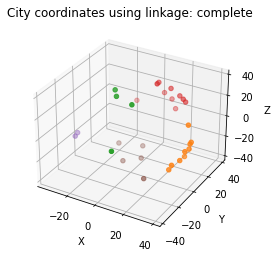

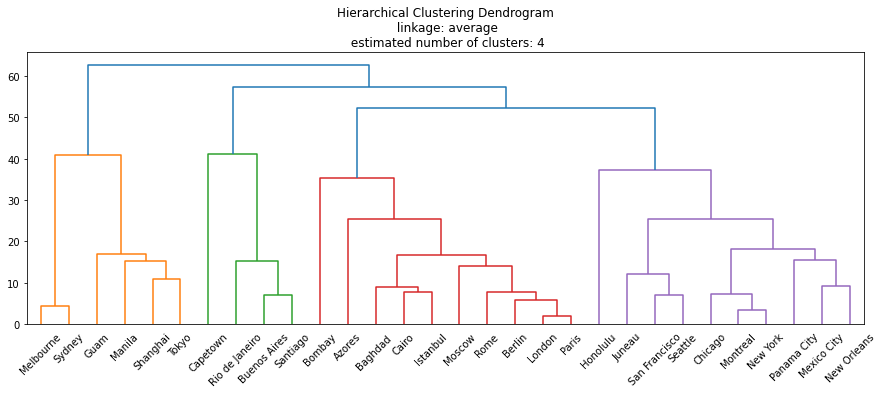

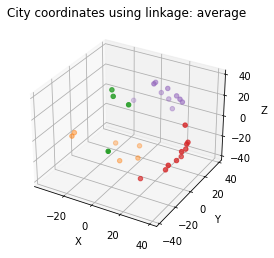

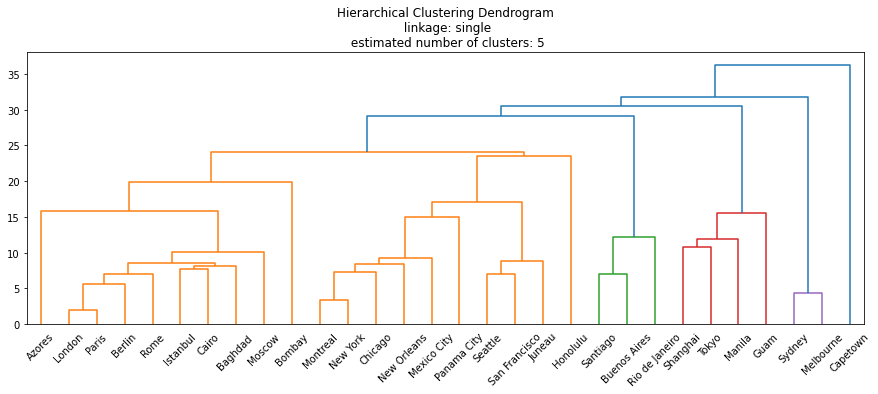

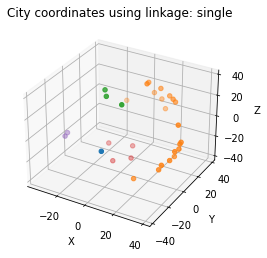

In [5]:
linkages = ["ward", "complete", "average", "single"]
models = []
dendos = []

for linkage in linkages:

    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(
        distance_threshold=0, linkage=linkage,n_clusters=None
    )
    model = model.fit(X)

    # plot the dendrogram
    fig, ax, dendo = plot_dendrogram(model, y)
    
    # The ideal number of clusters is estimated by considering the height 
    # of each link by the dendogram function in scipy
    # To get the estimated number of cluster, we count the number of different
    # colors in the leaves
    n_clusters = len(set(dendo["leaves_color_list"]))
    plt.title(
        "Hierarchical Clustering Dendrogram" 
        + "\n linkage: " + linkage 
        + "\n estimated number of clusters: " + str(n_clusters)
    )
    fig, ax = plot_3D_coordinates(X, dendo)
    plt.title("City coordinates using linkage: " + linkage)
    
    plt.show()
    
    models.append(model)
    dendos.append(dendo)
    

## Image segmentation 

### Loading the image 'scenery_184_233.txt'

Shape of image for clusterisation:  (42872, 3)


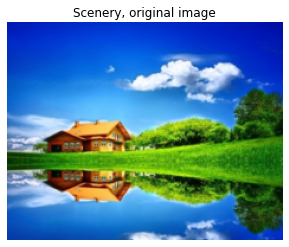

In [6]:
def load_image(filename="scenery_184_233.txt"):
    "Return the RGB image as a numpy array X of shape (H*W, 3)"
    X = []
    with open(filename, 'r') as scenery:
        for line in scenery.readlines():
            data = line.split()
            data = data[0].split(',')
            X.append(data)
    # Make sure we have the right format:
    X = np.array(X).astype(float)
    return X

def plot_image(X):
    """
    Plot the image represented by X of shape (H*W, 3)
    """
    # Copy of X for visualization purposes (of shape (H, W, 3))
    X_vis = np.expand_dims(X, axis=1).reshape(184, 233, 3)
    X_vis = np.uint8(X_vis)
    
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(X_vis)
    return fig, ax
    

X = load_image()

print("Shape of image for clusterisation: ", X.shape)

fig, ax = plot_image(X)
ax.set_title("Scenery, original image")
plt.show()


In [7]:
def get_masks(model, X):
    """
    returns masks and segmentation of the image X using a trained model
    """
    clusters = model.predict(X)
    mask_representatives = model.cluster_centers_
    n_masks = len(mask_representatives)
    masks = [np.ones_like(X)*mask_representatives[i] for i in range(n_masks)]
    segmentation = np.zeros_like(X)
    for i in range(n_masks):
        masks[i][clusters != i] = 0
        segmentation += masks[i]
    return masks, segmentation

### Training different Kmeans models

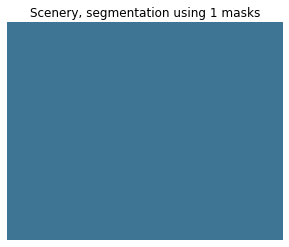

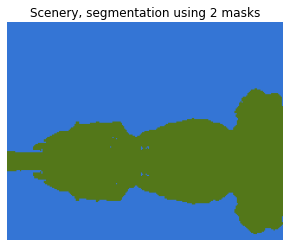

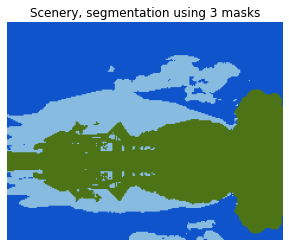

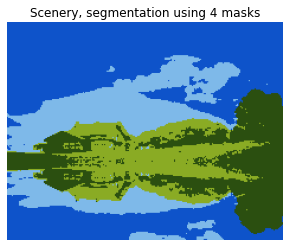

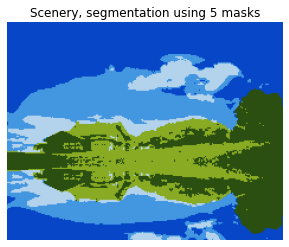

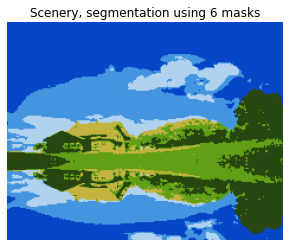

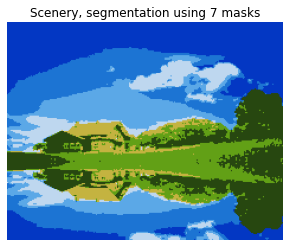

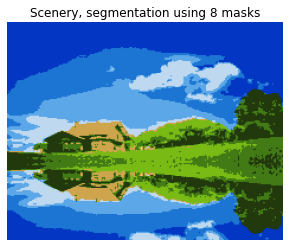

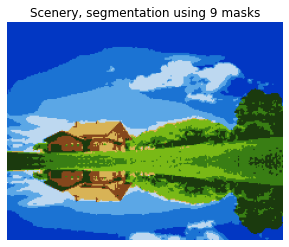

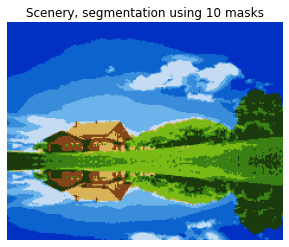

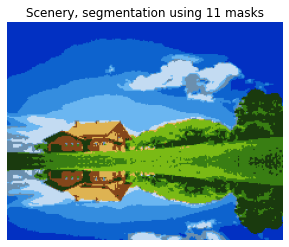

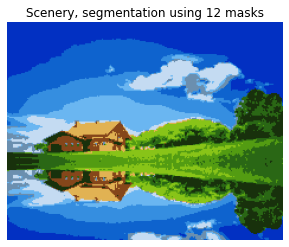

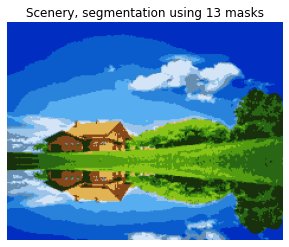

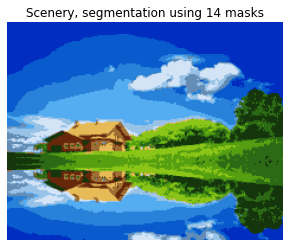

In [8]:
k_values = [i for i in range(1, 15)]
models = []
scores = []

for k in k_values:
    model = KMeans(k)
    model.fit(X)
    masks, segmentation = get_masks(model, X)
    
    fig, ax = plot_image(segmentation)
    ax.set_title("Scenery, segmentation using %d masks" %k)
    plt.show()
    
    scores.append(model.inertia_)
    models.append(model)


### Selecting the best model using the elbow method

K selected using the elbow method:  4


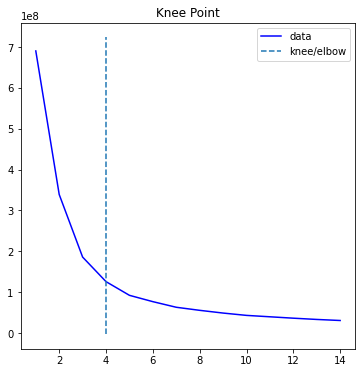

In [9]:
knee = KneeLocator(k_values, scores, curve="convex", direction="decreasing")
knee.plot_knee()
k_best = knee.elbow
print("K selected using the elbow method: ", k_best)

### Image segmentation using the selected model

Text(0.5, 1.0, 'Scenery, segmentation using the selected k, k=4')

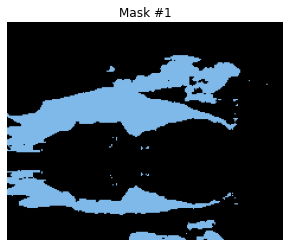

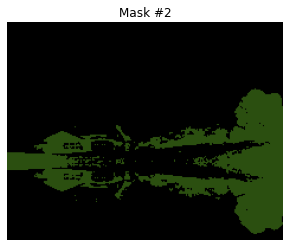

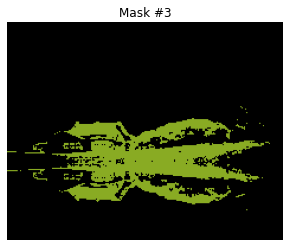

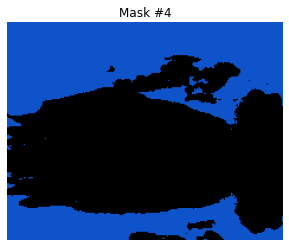

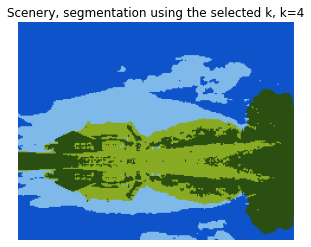

In [10]:
best_model = KMeans(k_best)
clusters = best_model.fit(X)
masks, segmentation = get_masks(best_model, X)
for i in range(k_best):

    fig, ax = plot_image(masks[i])
    ax.set_title("Mask #" + str(i+1))
    
fig, ax = plot_image(segmentation)
ax.set_title("Scenery, segmentation using the selected k, k="+str(k_best))
